# Ground truth comparison on neuropixel simulated with mearec

Author : Samuel Garcia

This notebook shows how [SpikeInterface](https://github.com/SpikeInterface) is used to perform a ground truth comparisong for multiple spike sorters on a simulated datsets with mearec that mimic a neuropixel dataset.

The dataset have been simulated by Alessio Buccino.
Duration : 300s
number of units : 250
Noise : 10uV
Nb channel: 384


Note the notebook assumes the recording is alreay sorted, the neccessary data can be downloaded here:


In [1]:
# import everything
import os, getpass

kilosort2_path = '/home/samuel/Documents/Spikeinterface/Kilosort2'
os.environ["KILOSORT2_PATH"] = kilosort2_path

kilosort_path = '/home/samuel/Documents/Spikeinterface/KiloSort/'
os.environ["KILOSORT_PATH"] = kilosort_path

ironclust_path = '/home/samuel/Documents/Spikeinterface/ironclust'
os.environ["IRONCLUST_PATH"] = ironclust_path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw

from spikeinterface.comparison import GroundTruthStudy

/home/samuel/.virtualenvs/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

# some matplotlib hack to prettify figure
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)   

## Check spikeinterface version and sorter version

In order to be a bit reproducible lets checks for versions of each sorter and spikeinterface subpackage.

In [3]:
si.print_spikeinterface_version()
ss.print_sorter_version()

spikeinterface: 0.9.1
  * spikeextractor: 0.7.1
  * spiketoolkit: 0.5.1
  * spikesorters: 0.2.2
  * spikecomparison: 0.2.2
  * spikewidgets: 0.3.2

herdingspikes: 0.3.3+git.f5232ac3520d
ironclust: 5.7.3
kilosort: git-cd040da1963d
kilosort2: git-67a42a87b866
klusta: 3.0.16
mountainsort4: unknown
spykingcircus: 0.9.0
tridesclous: 1.5.0


## Setup global path

In [4]:
p = Path('/home/samuel/Documents/DataSpikeSorting/mearec/')
study_folder = p / 'study_mearec_neuropixel/'

## Setup ground truth study

In [ ]:
# lets load from mearec file the recording (traces) and the true sorting (spiketrains and units)
mearec_filename = p / 'recordings_250cells_Neuropixels-384_300.0_10.0uV_06-07-2019_15-29.h5'
rec0  = se.MEArecRecordingExtractor(mearec_filename)
gt_sorting0 = se.MEArecSortingExtractor(mearec_filename)

# a study can have several pari of recording/GT sorting
# here we have only one
gt_dict = {'rec0' : (rec0, gt_sorting0) }

study = GroundTruthStudy.create(study_folder, gt_dict)

## Run all sorters

In [6]:
sorter_list = ['herdingspikes', 'ironclust', 'tridesclous']
# 'kilosort2',  'kilosort' : are buggy
# 'spykingcircus' is too slow

In [ ]:
study = GroundTruthStudy(study_folder)

# here we will take default params for each sorter engine
# but we could change it
sorter_params = {} 

study.run_sorters(sorter_list, sorter_params=sorter_params, mode='keep', verbose=True)

## Get signal to noise ratio for all units

In this simulation the SNR is very very high.

In [8]:
study = GroundTruthStudy(study_folder)
snr = study.get_units_snr()
snr.head(10)

,snr,rec_name
gt_unit_id,,
0,145.328920,rec0
1,41.815845,rec0
2,64.070230,rec0
3,37.149270,rec0
4,78.906630,rec0
5,45.986927,rec0
6,45.800970,rec0
7,106.206530,rec0
8,39.162740,rec0


Text(0.5, 0, 'GT units SNR')

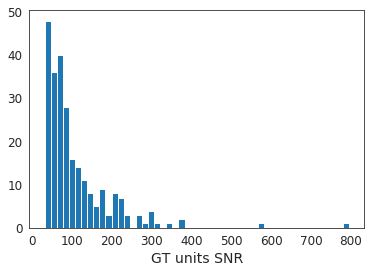

In [13]:
fig, ax = plt.subplots()
ax.hist(snr['snr'].values, bins=50)
ax.set_xlabel('GT units SNR')

## Run comparison with ground truth and retreive result tables

In [14]:
# this copy sorting is necessary to copy results from sorter
# into a centralize folder with all results
study.copy_sortings()

# this run all comparison sto GT
study.run_comparisons(exhaustive_gt=True, match_score=0.1, overmerged_score=0.2)

In [15]:
# this retrieve results
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

## Run times

In [16]:
dataframes['run_times']

,rec_name,sorter_name,run_time
0,rec0,herdingspikes,425.737426
1,rec0,ironclust,542.226971
2,rec0,tridesclous,2321.893354


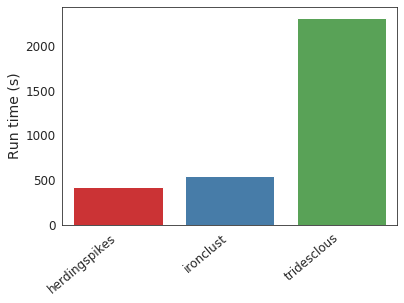

In [18]:
fig, ax = plt.subplots()
sns.barplot(data=dataframes['run_times'], x='sorter_name', y='run_time', ax=ax, order=sorter_list)

sns.set_palette(sns.color_palette("Set1"))
ax.set_ylabel('Run time (s)');
ax.set_xlabel(None);
ax.set_xticklabels(sorter_list, rotation=40, ha='right');

## confusion matrix

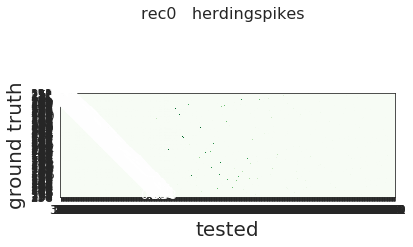

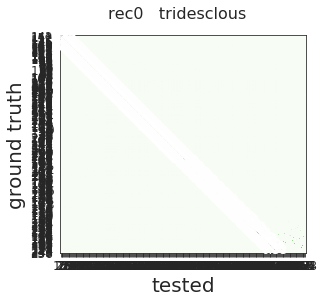

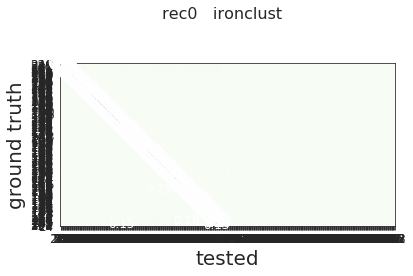

In [19]:
for (rec_name, sorter_name), comp in comparisons.items():
    fig, ax = plt.subplots()
    sw.plot_agreement_matrix(comp, ax=ax)
    fig.suptitle(rec_name+'   '+ sorter_name)

## accuracy/precision/recall scores per sorters

In [23]:
dataframes['perf_by_units']

,rec_name,sorter_name,gt_unit_id,accuracy,recall,precision,false_discovery_rate,miss_rate
0,rec0,herdingspikes,0,0.969841,0.975,0.994574,0.00542594,0.025
1,rec0,herdingspikes,1,0.519856,0.972973,0.527473,0.472527,0.027027
2,rec0,herdingspikes,2,0.914373,0.940252,0.970779,0.0292208,0.0597484
3,rec0,herdingspikes,3,0.857784,0.901652,0.946325,0.0536746,0.0983478
4,rec0,herdingspikes,4,0.875348,0.897319,0.972789,0.0272109,0.102681
...,...,...,...,...,...,...,...,...
745,rec0,ironclust,245,0,0,0,0,0
746,rec0,ironclust,246,0.977584,0.978045,0.999517,0.000482509,0.0219547
747,rec0,ironclust,247,0.326953,0.987363,0.328327,0.671673,0.0126375
748,rec0,ironclust,248,0.92528,0.976561,0.946296,0.0537041,0.0234392


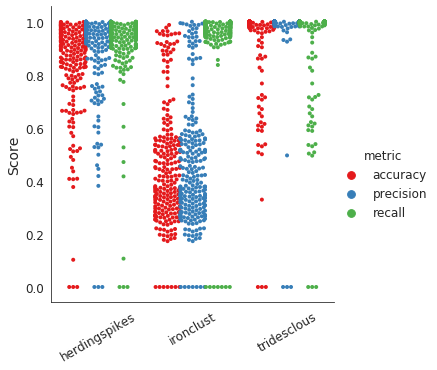

In [37]:
sns.set_palette(sns.color_palette("Set1"))

df = pd.melt(dataframes['perf_by_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('accuracy','precision', 'recall'))
grid = sns.catplot(data=df, x='sorter_name', y='score', hue='metric', kind='swarm', dodge=True,
                order=sorter_list, legend_out=True, s=4)
ax = grid.fig.axes[0]
ax.set_xticklabels(sorter_list, rotation=30, ha='center')
ax.set_xlabel(None);
ax.set_ylabel('Score');
clear_axes(ax)

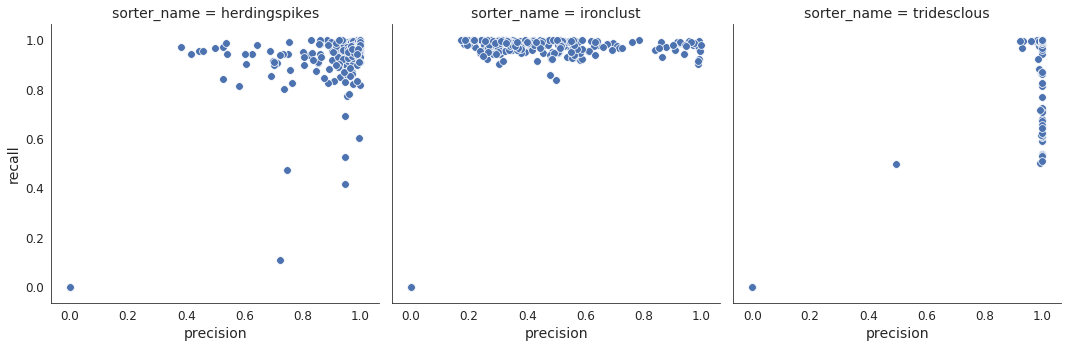

In [39]:
sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], 
                x='precision', y='recall', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)

## count units

  * well detected
  * false positive
  * redundant
  * overmerged

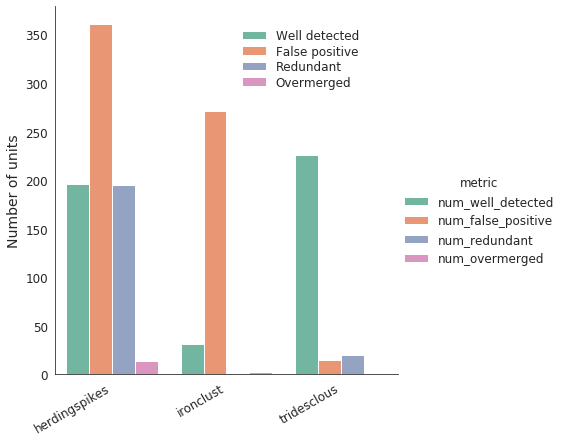

In [41]:
sns.set_palette(sns.color_palette("Set2"))

df = pd.melt(dataframes['count_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
grid = sns.catplot(x='sorter_name', y='score', hue='metric', data=df,
                height=6, kind="bar", ax=ax, order=sorter_list)
ax = grid.fig.axes[0]
ax.set_xticklabels(sorter_list, rotation=30, ha='right')

ax.legend(bbox_to_anchor=(0.9, 0.95), borderaxespad=0., frameon=False, labelspacing=0.2)
for t, l in zip(ax.legend_.texts,("Well detected", "False positive", "Redundant", "Overmerged")):
    t.set_text(l)

ax.set_xlabel(None);
ax.set_ylabel('Number of units');
clear_axes(ax)

## Accuracy vns SNR

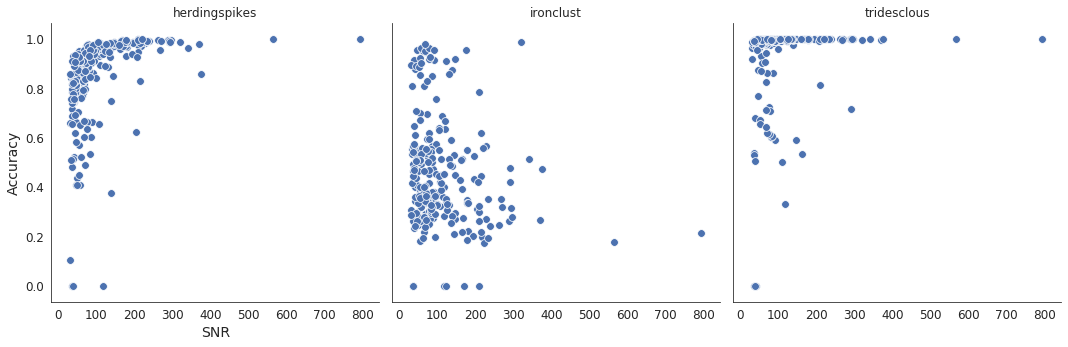

In [44]:
df = dataframes['perf_by_units']

# add snr to the by-unit table
df['snr'] = None
for gt_id in snr.index:
    df['snr'].loc[df['gt_unit_id']==gt_id] = snr.at[gt_id, 'snr']



sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], x='snr', y='accuracy', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)
for i,ax in enumerate(g.axes):
    ax.set_title(sorter_list[i])
    ax.set_xlabel('')
    g.axes[0].set_xlabel('SNR');

g.axes[0].set_ylabel('Accuracy');